In [ ]:
!pip install neuromancer

In the cell below we implement and solve the following Optimization problem via Gradient Descent based methods in NeuroMANCER:
\begin{equation}
    \boldsymbol{\hat{x}} = \arg \min_{\boldsymbol{x}} ||\boldsymbol{y}-H\boldsymbol{x}||_2^{2} + \lambda ||\Phi \boldsymbol{x}||_1
\end{equation}
\begin{equation*}
    s.t. \ \boldsymbol{x} \geq 0
\end{equation*}

The background and context for the work here is inspired by the Techincal Proposal for enhancing NeuroMANCER's capabilities.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import neuromancer.slim as slim
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
import casadi
import time

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.constraint import variable
from neuromancer.dataset import DictDataset
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks, solvers
from neuromancer.system import Node

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

Load the MNIST Data Set as an example

In [2]:
import subprocess

# Installation on Google Colab
try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install', 'skorch' , 'torch'])
except ImportError:
    pass




mnist = fetch_openml('mnist_784', as_frame=False, cache=False) # Get Data Set

In [3]:
# Convert to float
X = mnist.data.astype('float32')
X /= 255.0
X.shape

(70000, 784)

In [4]:
# plt.imshow(X[0, :].reshape(28, 28), cmap = 'gray')

Now that we have loaded the MNIST Data Set, the idea is that we assume that the hand written digits were captured by a Camera with forward model $H$.
Given the forward model $H$, we pass in the MNIST Data Set points through $H$ and generate Training Data for the model defined below.

Directions for experiments:


*   Change the output measurement dimension $m$ such that $m <<$ input measurement (in this case 784)
* Change the parameter $\tau > 0$ to promote sparsity
* Change "data" variable to collect more subsets of data



**Construct Data Set**

In [22]:
np.random.seed(42) # for indices

In [24]:
# Extract subset from Original Data Set of 70 000 images

data = 20000

X_sampled = torch.from_numpy(X[:data :])


m = 400   # Dimension of output measurement (m must be << 784)
n = X_sampled.shape[1] # Input dimension of collected data

# Assume Forward model matrix is given to you

H = torch.randn(m, n)

# Assume Sparisty Basis is given, obtained via QR Decomposition

A = torch.randn(n, n)
Q, R = torch.qr(A)  # Q is an orthogonal matrix
Phi = Q


# Passs through Forward model

Y = X_sampled @ H.T # shape (reduced, m)


indices = np.random.permutation(Y.shape[0])

split_size = 5000
indices1 = indices[:split_size] # for train
indices2 = indices[split_size:2*split_size] # for dev
indices3 = indices[2*split_size:3*split_size] # for test




# Generate random measurements from Camera Model for train, dev, and test sets
samples_train = {
    "y": Y[indices1, :]
}

samples_dev = {
    "y": Y[indices2, :]
}

samples_test = {
    "y": Y[indices3, :]
}

# create named dictionary datasets
train_data = DictDataset(samples_train, name='train')
dev_data = DictDataset(samples_dev, name='dev')
test_data = DictDataset(samples_test, name='test')

# create torch dataloaders for the Trainer
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=0,
                                           collate_fn=train_data.collate_fn, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=32, num_workers=0,
                                         collate_fn=dev_data.collate_fn, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, num_workers=0,
                                         collate_fn=test_data.collate_fn, shuffle=True)

In [25]:
# define neural architecture for the trainable solution map
func = blocks.MLP(insize=m, outsize=n,         # input size corresponds to the measurement and output size corresponds to reconstructed input
                bias=True,
                linear_map=slim.maps['linear'],
                nonlin=nn.ReLU,
                hsizes= [80] * 4)
# wrap neural net into symbolic representation of the solution map via the Node class: sol_map(xi) -> x
sol_map = Node(func, ['y'], ['x'], name='map')

In [26]:
out = func(samples_train['y'])
print(out)

tensor([[ 0.0376, -0.1082, -0.2262,  ..., -0.1316,  0.0469, -0.1396],
        [ 0.0343, -0.0577, -0.0990,  ..., -0.1901,  0.0423, -0.1625],
        [ 0.0039, -0.0700, -0.0621,  ..., -0.0834,  0.0858, -0.0803],
        ...,
        [ 0.0678, -0.0221, -0.0322,  ..., -0.1824,  0.0516, -0.1276],
        [ 0.0211, -0.0504,  0.0100,  ..., -0.2598,  0.3116, -0.0617],
        [ 0.1970, -0.1129, -0.1246,  ..., -0.3562,  0.1874, -0.2123]],
       grad_fn=<AddmmBackward0>)


In [27]:
out.shape

torch.Size([5000, 784])

In [28]:
test = samples_train['y']
test.shape

torch.Size([5000, 400])

Define decision and primal variables, and parameters, along with objective to minimize

In [29]:
# define primal decision variables
x = variable("x")
# problem parameters sampled in the dataset
y = variable('y')

# Regularizer for sparsity
tau = 0.8

# objective function
f = torch.norm(y - (x @ H.T), p = 2) ** 2 + (tau * torch.norm(x @ Phi.T, p = 1)) # non smooth regularizer
obj = f.minimize(weight=1.0, name='obj')

# constraints
Q_con = 1.0  # constraint penalty weights set deliberately too low to demonstrate
con_1 = Q_con * (x >= 0) # non negativity constraint
con_1.name = 'c1'

In [30]:
# instantiate projected gradient layer to correct the solutions from the neural net:
# proj(sol_map(xi)) -> x
num_steps = 5
step_size = 0.1
proj = solvers.GradientProjection(constraints = [con_1],          # inequality constraints to be corrected
                                  input_keys = ["x"],                    # primal variables to be updated
                                  num_steps = num_steps,                 # number of rollout steps of the solver method
                                  step_size = step_size,                 # step size of the solver method
                                  decay = 0.1,                           # decay factor of the step size
                                  name = 'proj')

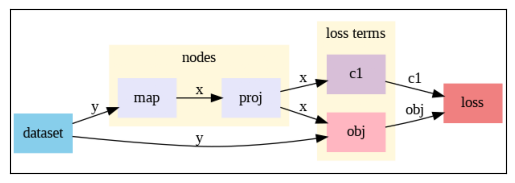

In [31]:
# constrained optimization problem construction
objectives = [obj]
constraints = [con_1]
components = [sol_map, proj]

# create penalty method loss function
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss,
                  grad_inference=True   # argument for allowing computation of gradients at the inference time
                  )
problem.show()

In [33]:
lr = 0.001      # step size for gradient descent
epochs = 100    # number of training epochs
warmup = epochs    # number of epochs to wait before enacting early stopping policy
patience = epochs  # number of epochs with no improvement in eval metric to allow before early stopping

In [34]:
optimizer = torch.optim.AdamW(problem.parameters(), lr=lr)

# define trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_loader,
    optimizer,
    epochs=epochs,
    patience=patience,
    warmup=warmup)

In [35]:
# Train NLP solution map
best_model = trainer.train()
best_outputs = trainer.test(best_model)
# load best model dict
problem.load_state_dict(best_model)

epoch: 0  train_loss: 500354.4375
epoch: 1  train_loss: 293213.0625
epoch: 2  train_loss: 242667.546875
epoch: 3  train_loss: 218001.984375
epoch: 4  train_loss: 202158.84375
epoch: 5  train_loss: 192163.40625
epoch: 6  train_loss: 185323.078125
epoch: 7  train_loss: 180593.15625
epoch: 8  train_loss: 177193.5625
epoch: 9  train_loss: 174659.421875
epoch: 10  train_loss: 171936.8125
epoch: 11  train_loss: 168269.78125
epoch: 12  train_loss: 164734.515625
epoch: 13  train_loss: 162763.015625
epoch: 14  train_loss: 160938.359375
epoch: 15  train_loss: 159414.859375
epoch: 16  train_loss: 157727.46875
epoch: 17  train_loss: 156778.03125
epoch: 18  train_loss: 155379.5625
epoch: 19  train_loss: 153712.390625
epoch: 20  train_loss: 152889.421875
epoch: 21  train_loss: 151042.078125
epoch: 22  train_loss: 150520.796875
epoch: 23  train_loss: 149621.171875
epoch: 24  train_loss: 148478.453125
epoch: 25  train_loss: 147994.453125
epoch: 26  train_loss: 146728.203125
epoch: 27  train_loss: 1455

<All keys matched successfully>

In [36]:
# selected image data for reconstruction
import random

i = random.randint(0, 1000) # sample index for testing

y_sample = Y[i, :]

# Solution to mpNLP via Neuromancer, forward pass
datapoint = {'y': torch.tensor(y_sample), 'name': 'test'}
model_out = problem(datapoint)

<ipython-input-36-dad934e14982>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  datapoint = {'y': torch.tensor(y_sample), 'name': 'test'}


Text(0.5, 1.0, 'Original Sample')

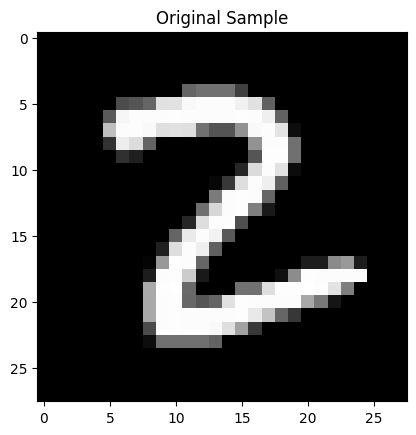

In [37]:
# Show solution original image
plt.imshow(X_sampled[i, :].reshape(28, 28), cmap = 'gray')
plt.title('Original Sample')

Text(0.5, 1.0, 'Reconstructed Sample with NeuroMANCER')

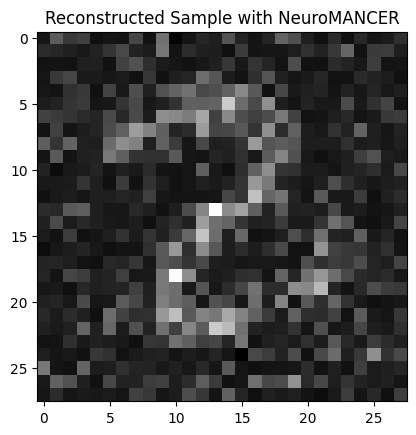

In [38]:
# Show solution i.e. the approximation
show_out = model_out['test_' + "x"].detach().numpy()
plt.imshow(show_out.reshape(28, 28), cmap = 'gray')
plt.title('Reconstructed Sample with NeuroMANCER')

Now, we will compare the solution with the built in ADMM approach in CVXPY

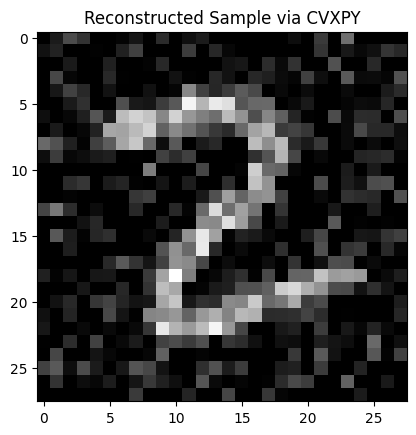

In [39]:
import cvxpy as cp

# define var in CVPXY
x = cp.Variable(H.shape[1], nonneg=True)

# define objective
objective = cp.Minimize(
    cp.sum_squares(y_sample - H @ x) + tau * cp.norm1(Phi @ x)
)

# solve the problem
prob = cp.Problem(objective)
result = prob.solve()

# result
x_hat = x.value

# Reshape and plot the solution if it's an image
plt.imshow(x_hat.reshape(28, 28), cmap='gray')
plt.title('Reconstructed Sample via CVXPY')
plt.show()

In [40]:
# compute MSE between the two estimated outputs
mse = np.mean((show_out - x_hat) ** 2) * 100
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 4.285096269693738


From what we can see in the above example, by using cvxpy, it gives us a solution that is nicer than the one used by NeuroMANCER, thus suggesting that NeuroMANCER might need improvement possibly in handling non smooth regularizers. Therefore, a new research direction, is in improving this capabiltiy.

Although the result obtained by NeuroMANCER is actually good (maybe a bit noisy), we can still qualitatively see the differences between the two sample outputs.